In [1]:
import pickle

from keras.models import Model, Sequential
from keras.layers import Input, SpatialDropout1D, GRU, LSTM, Conv1D, concatenate, Dense
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
X_train, y_train = pickle.load(open( "dict.pickle", "rb" ))

In [3]:
model = Sequential()
model.add(LSTM(512, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(256, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(X_train.shape[2]))

In [4]:

model.compile(loss = 'mae', optimizer = Adam(lr = 1e-3))

cp_callbacks = ModelCheckpoint(filepath = "recurrent_model_initial.h5", monitor = "val_loss", mode = 'min', save_best_only = True, verbose = 1)

model.fit(X_train, y_train, epochs = 40, batch_size = 16, validation_split = 0.25, callbacks = [cp_callbacks])

Train on 1685 samples, validate on 562 samples
Epoch 1/40
1685/1685 [==============================] - 8s 5ms/step - loss: 0.2844 - val_loss: 0.3562

Epoch 00001: val_loss improved from inf to 0.35616, saving model to recurrent_model_initial.h5
Epoch 2/40
1685/1685 [==============================] - 3s 2ms/step - loss: 0.2144 - val_loss: 0.3416

Epoch 00002: val_loss improved from 0.35616 to 0.34165, saving model to recurrent_model_initial.h5
Epoch 3/40
1685/1685 [==============================] - 3s 2ms/step - loss: 0.1676 - val_loss: 0.2768

Epoch 00003: val_loss improved from 0.34165 to 0.27678, saving model to recurrent_model_initial.h5
Epoch 4/40
1685/1685 [==============================] - 4s 2ms/step - loss: 0.1467 - val_loss: 0.2766

Epoch 00004: val_loss improved from 0.27678 to 0.27658, saving model to recurrent_model_initial.h5
Epoch 5/40
1685/1685 [==============================] - 4s 2ms/step - loss: 0.1330 - val_loss: 0.2357

Epoch 00005: val_loss improved from 0.27658 to

In [5]:
model = keras.models.load_model("recurrent_model_initial.h5")

validation_target = y_train[3*len(X_train)//4:]
validation_predictions = []
error = []

# index of first validation input
i = 3*len(X_train)//4

while len(validation_predictions) < len(validation_target) - 1:
  p = model.predict(X_train[i].reshape(1, X_train.shape[1], X_train.shape[2]))[0] 
  i += 1

  error.append(mean_absolute_error(p,y_train[i]))
  # update the predictions list
  validation_predictions.append(p)

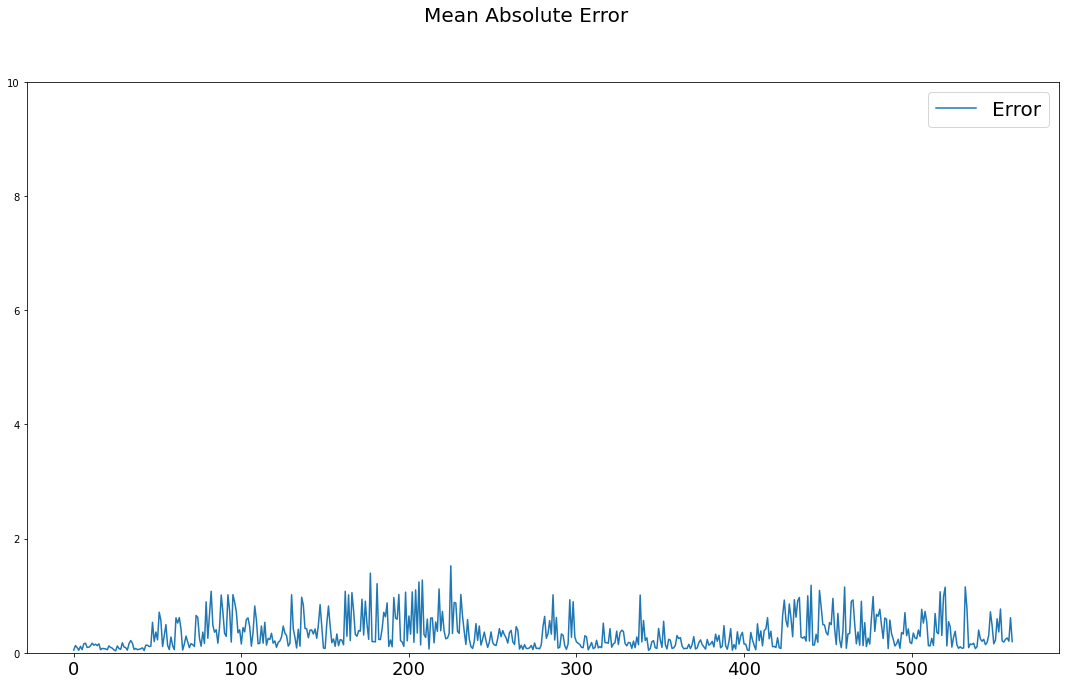

In [10]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Mean Absolute Error', size=20)
plt.plot(error, label='Error')
plt.xticks(fontsize=18)
plt.ylim(0, 10)
plt.legend(prop={'size': 20})
plt.show()

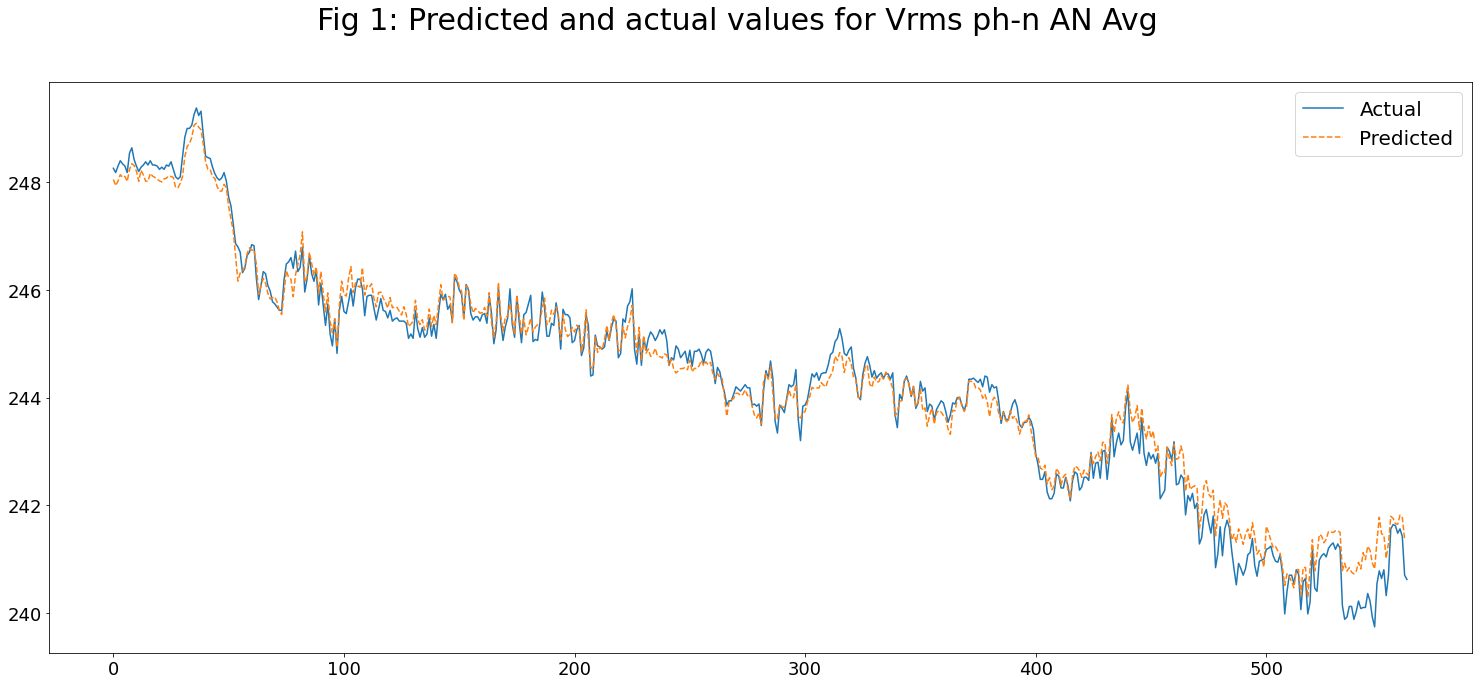

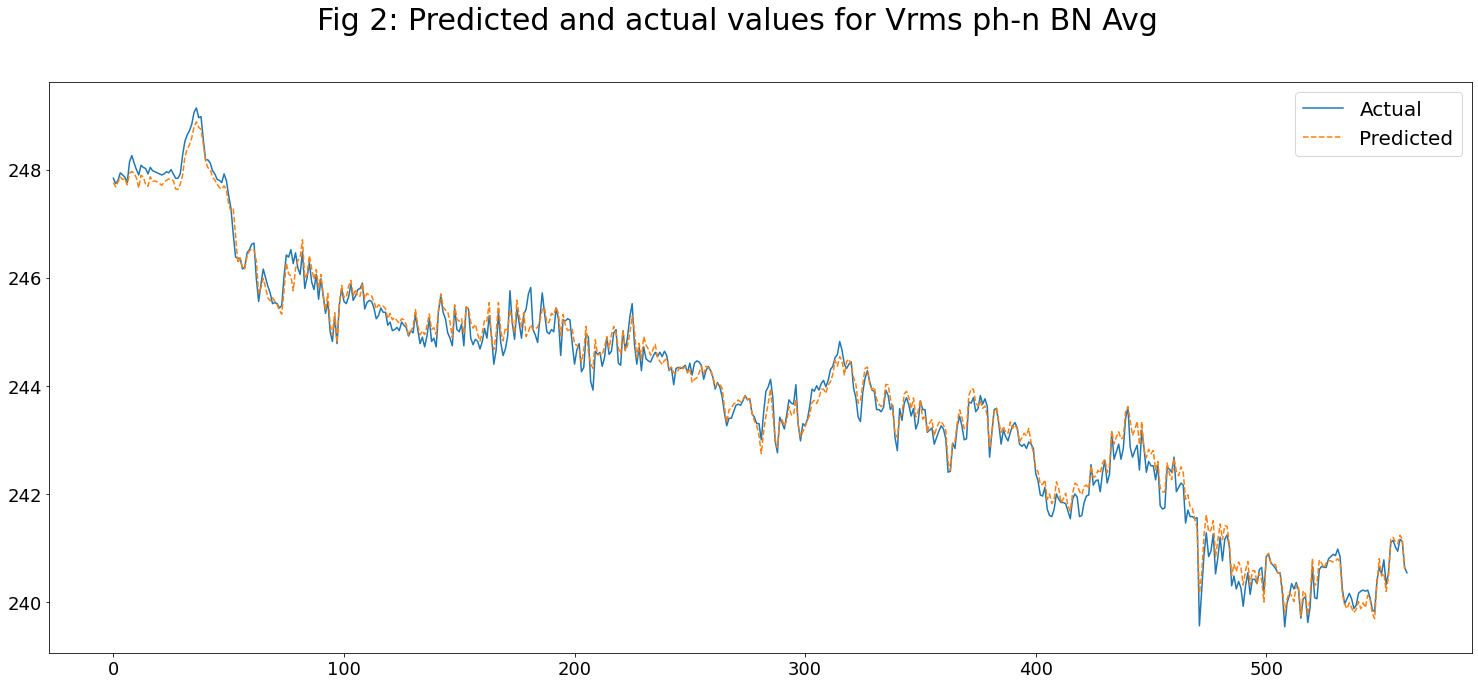

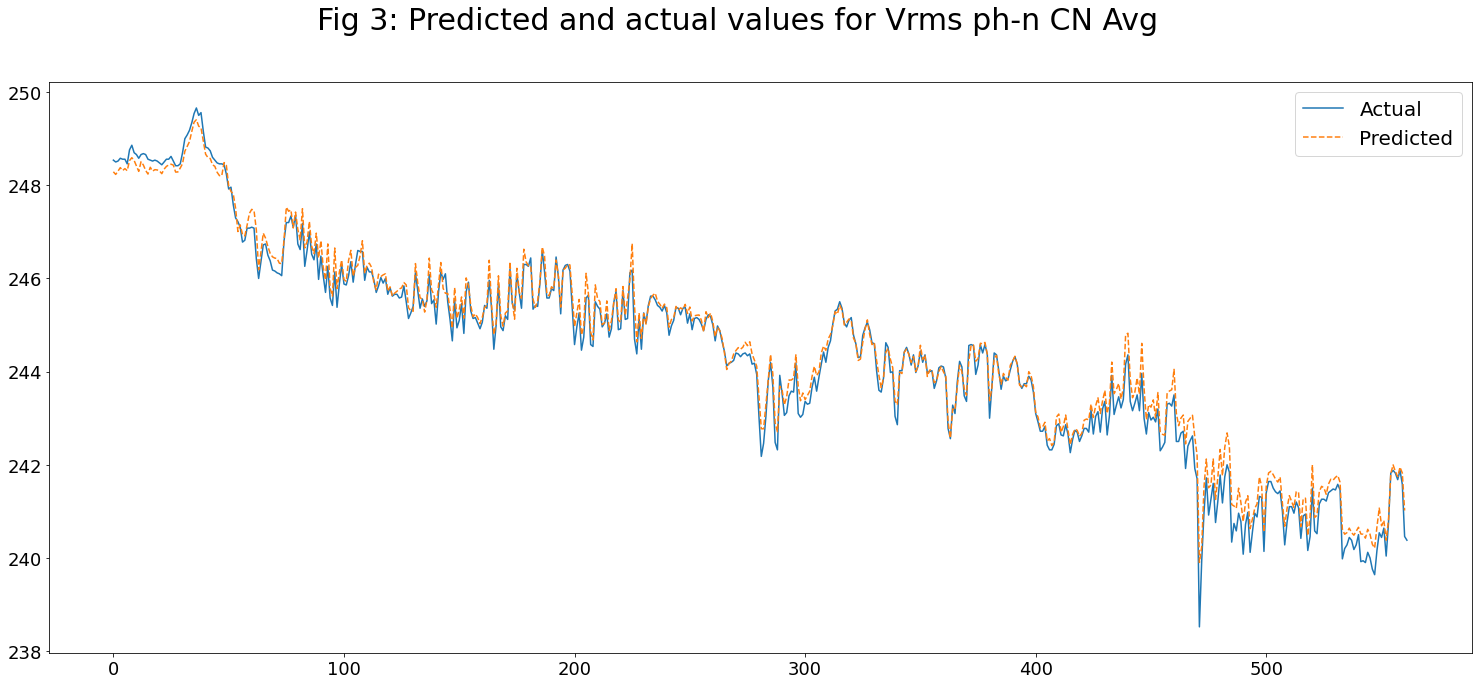

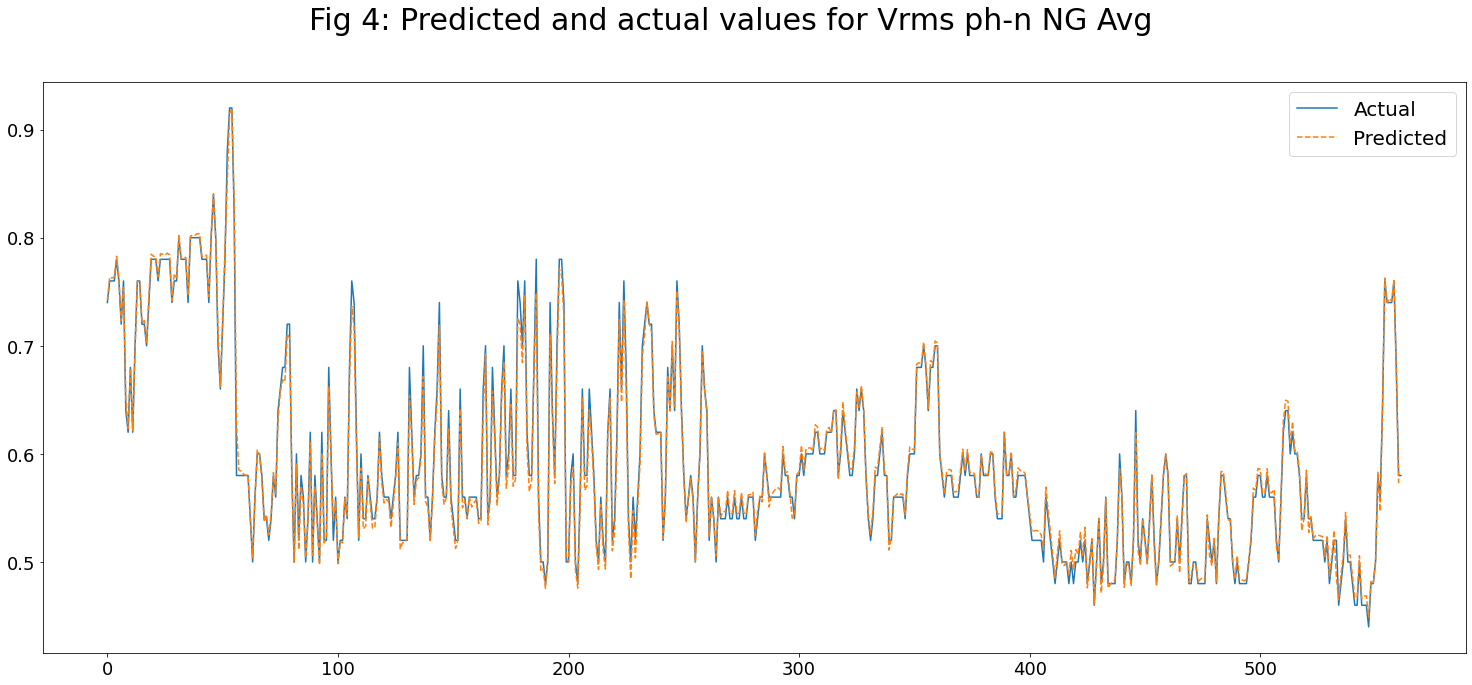

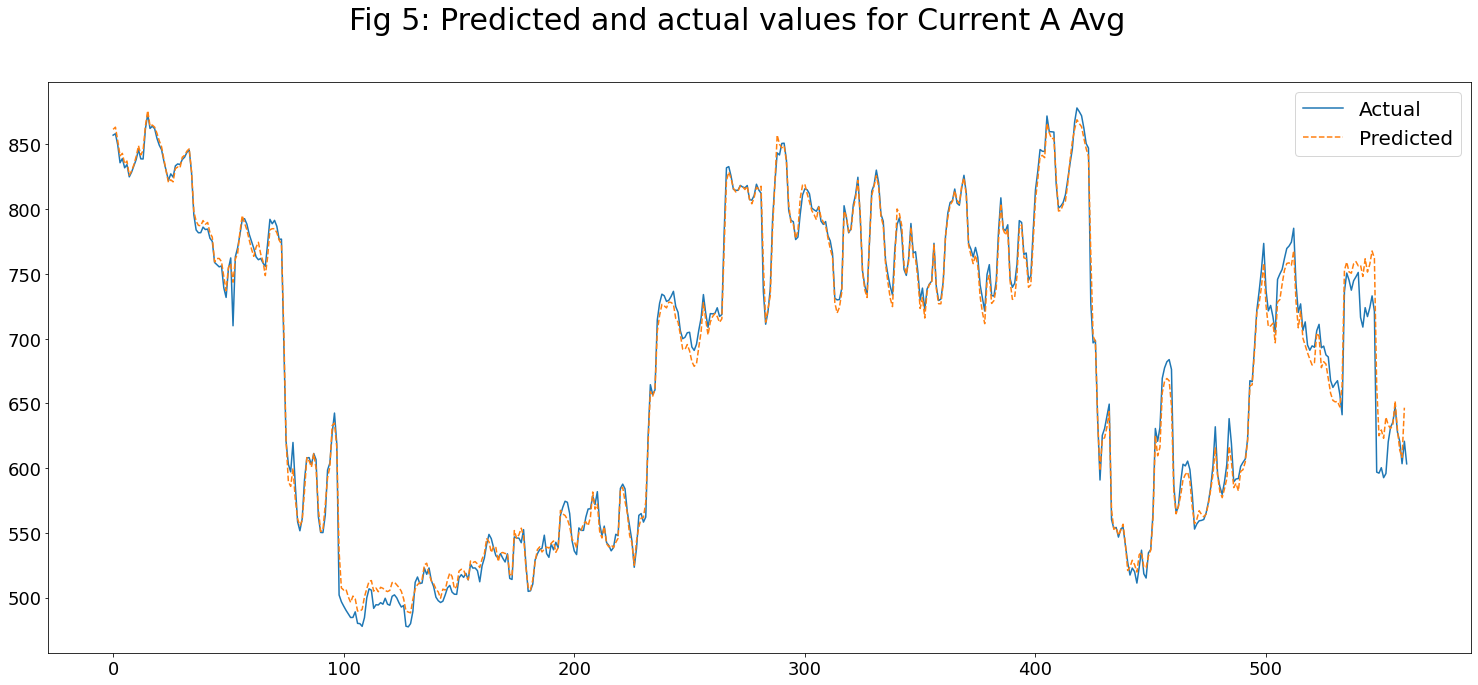

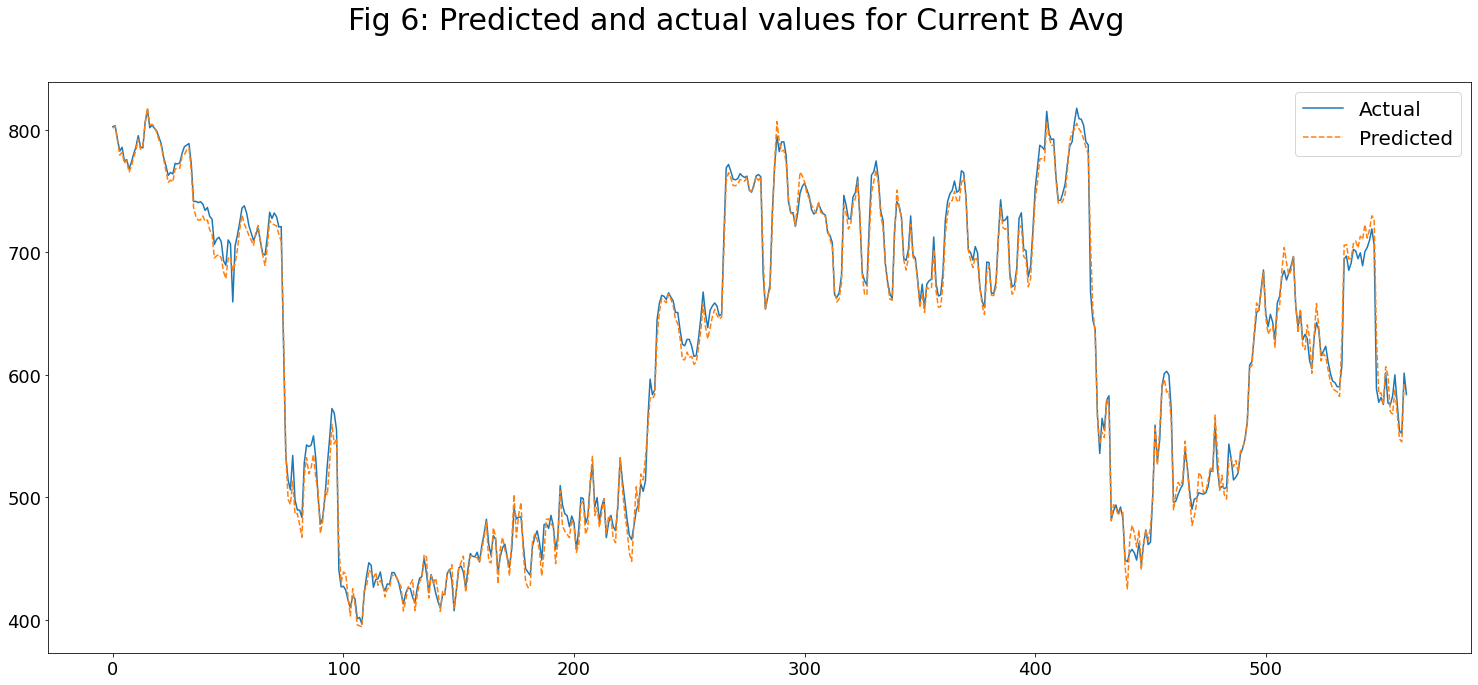

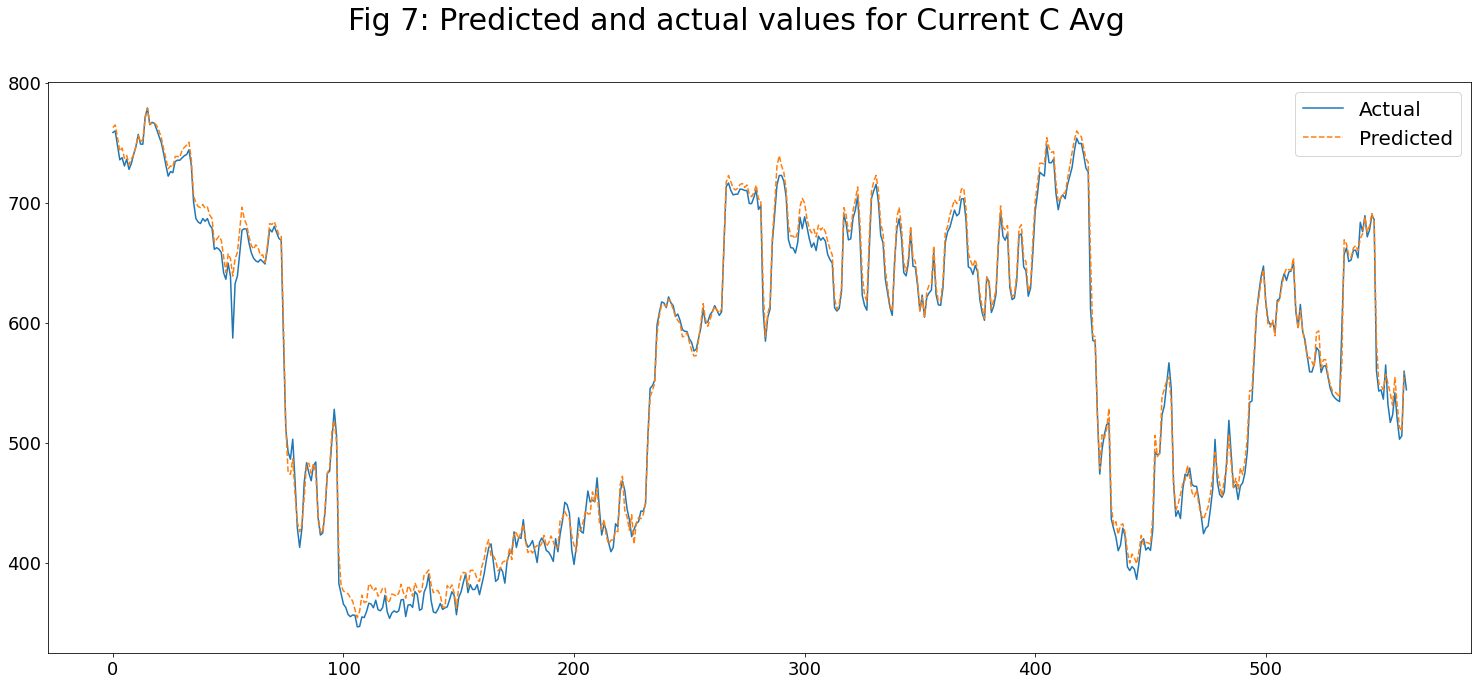

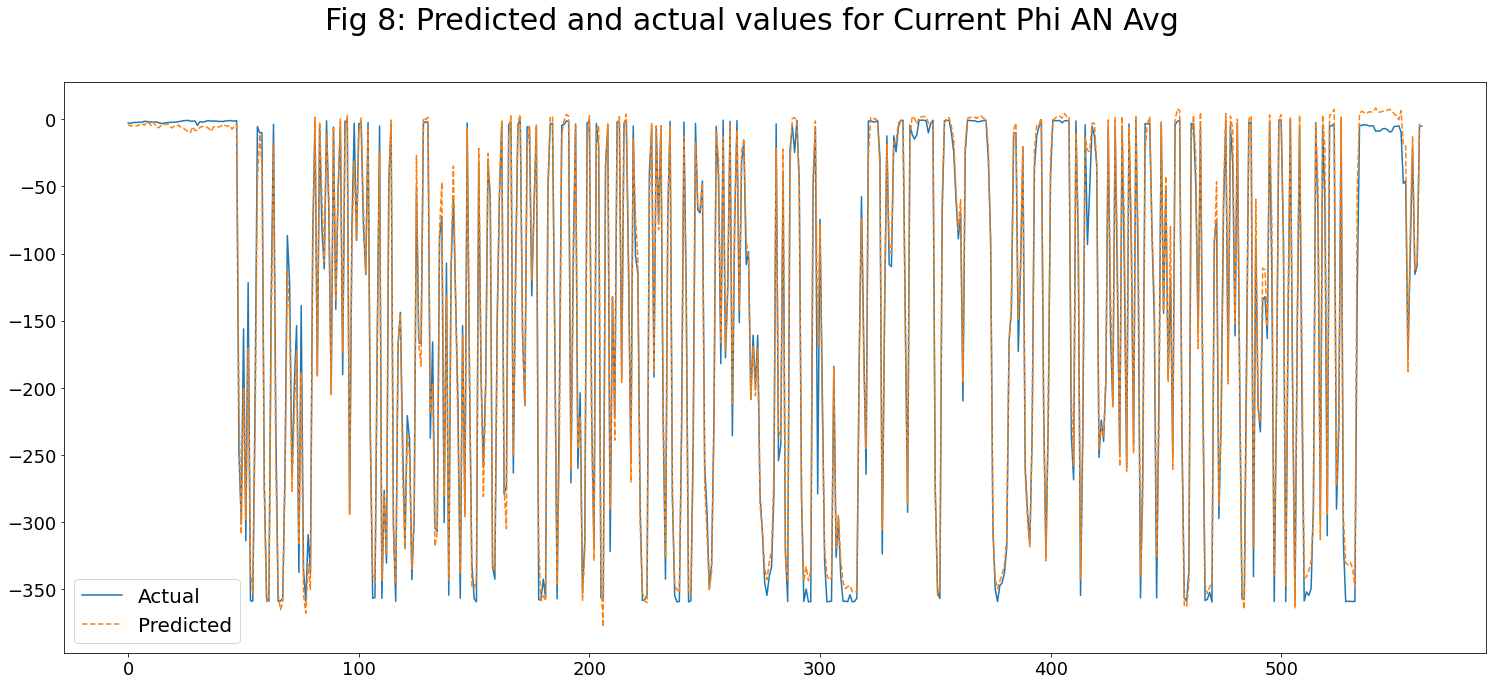

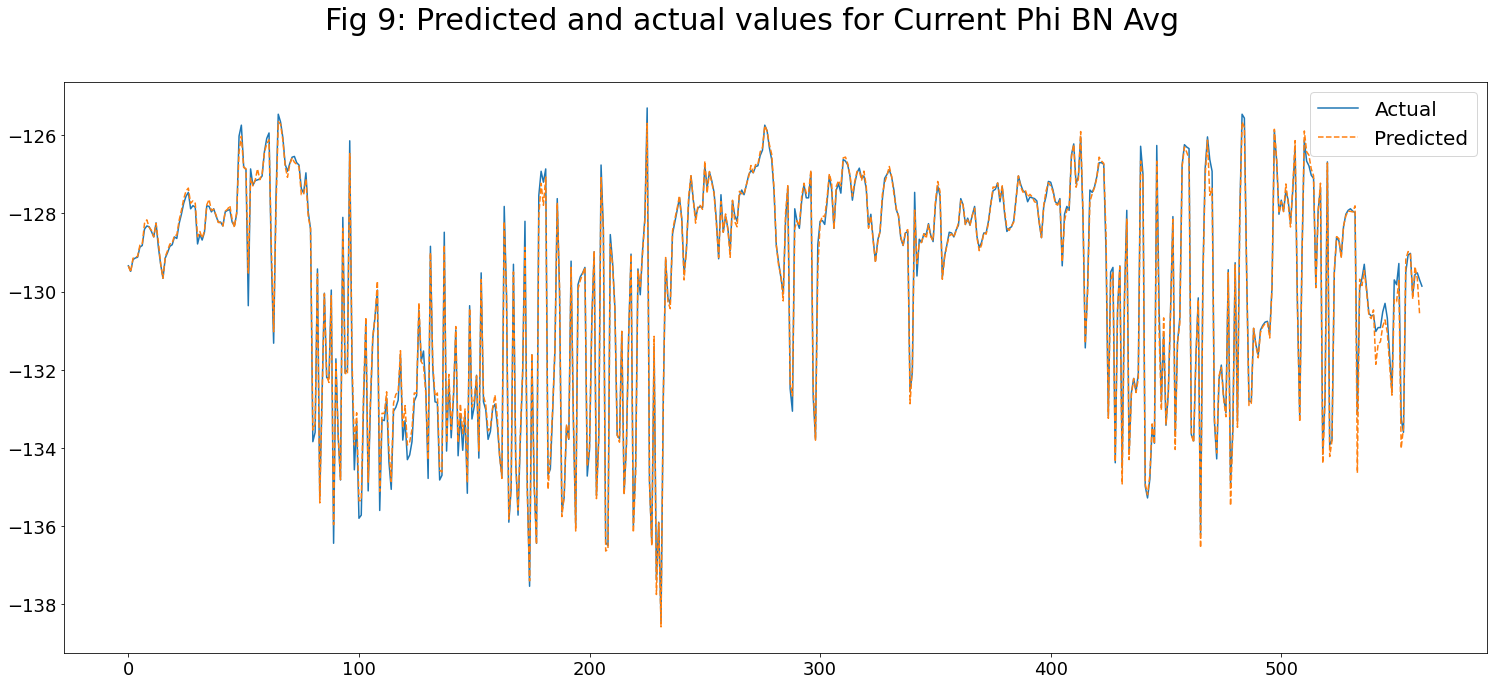

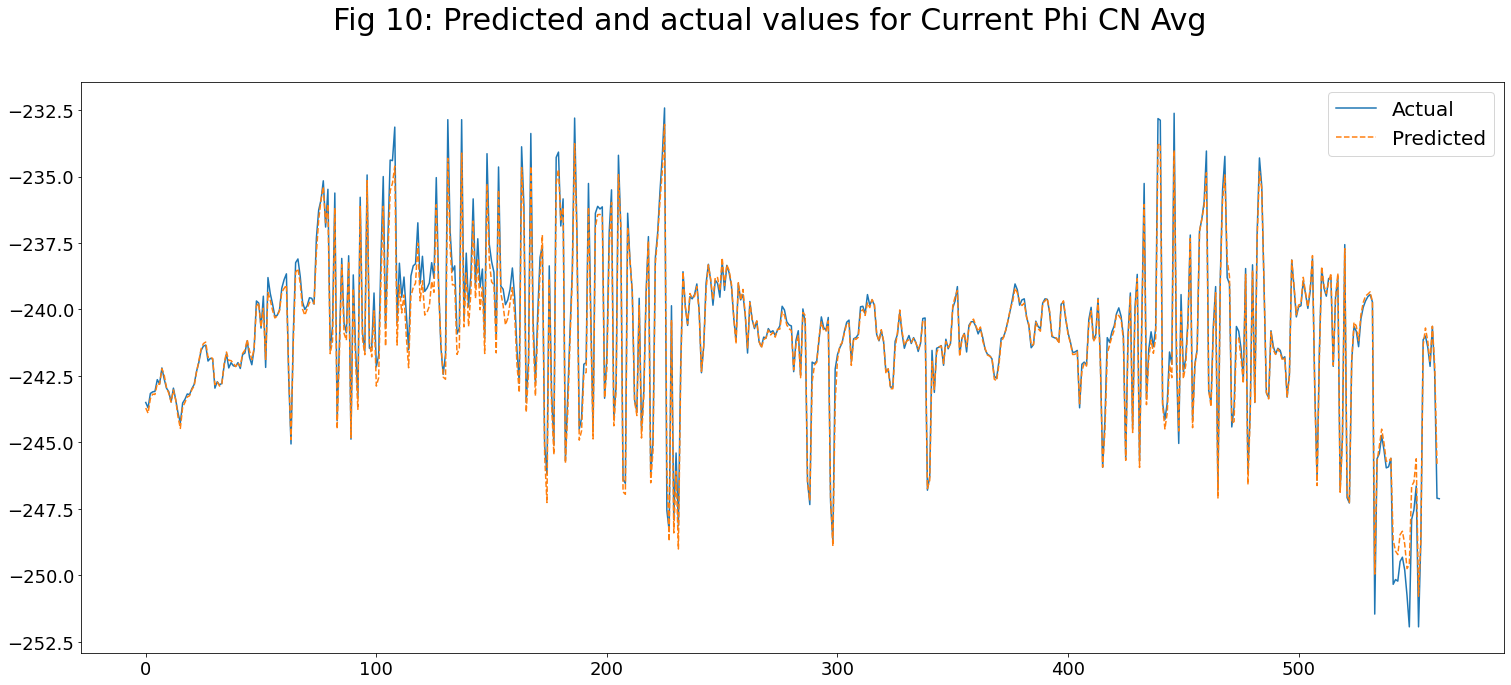

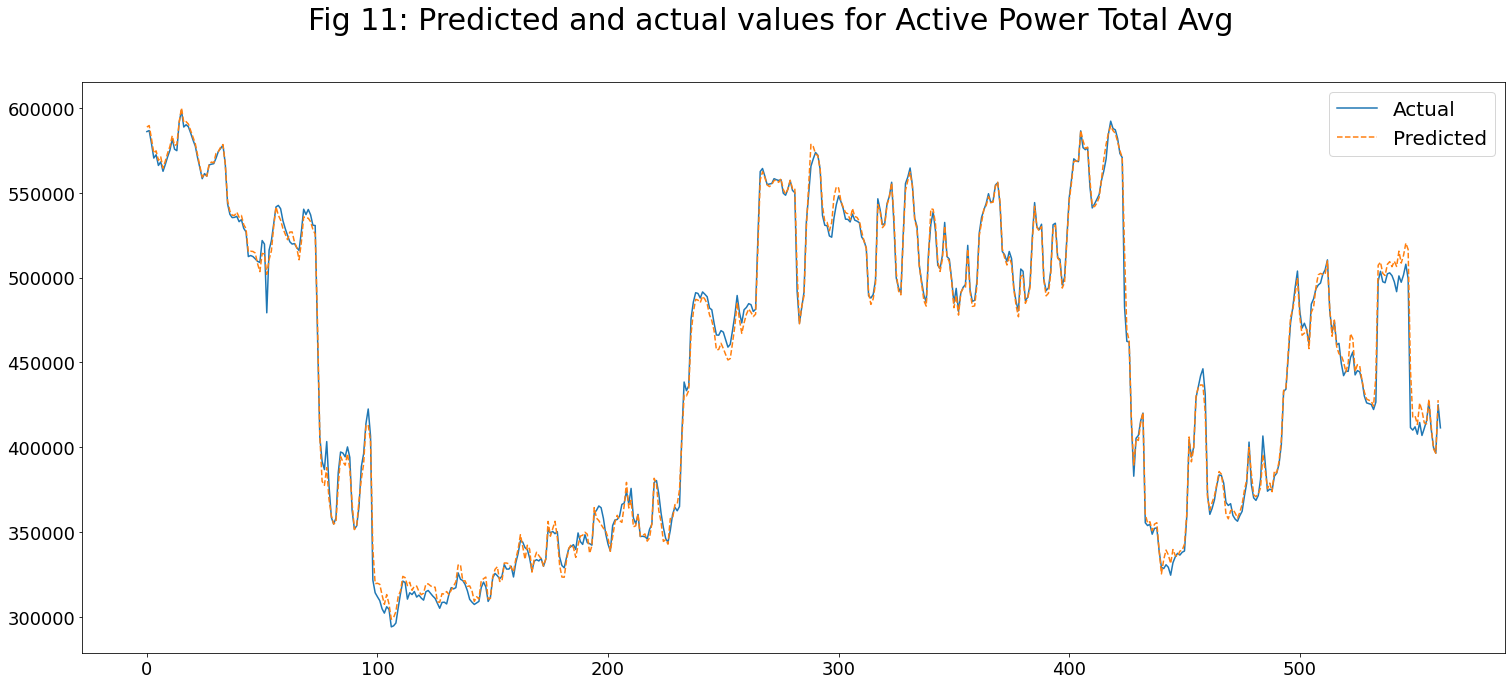

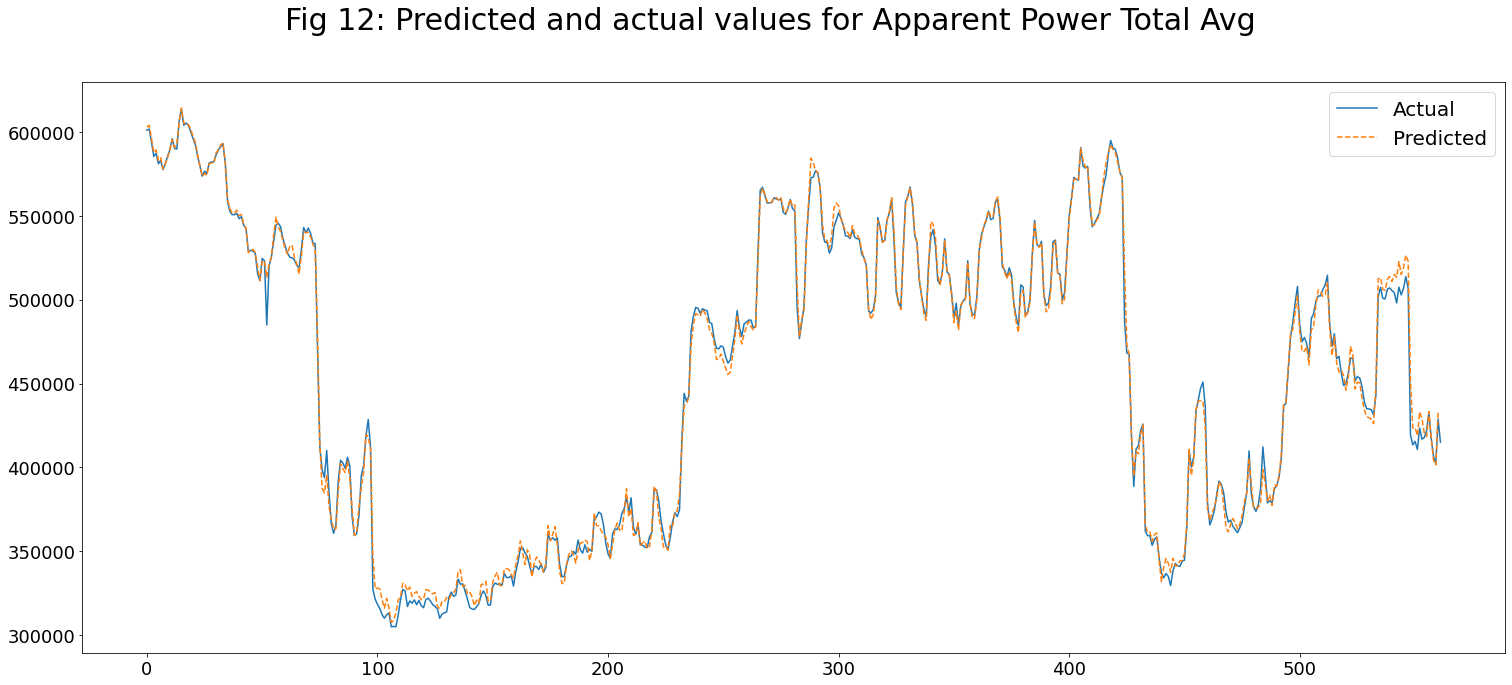

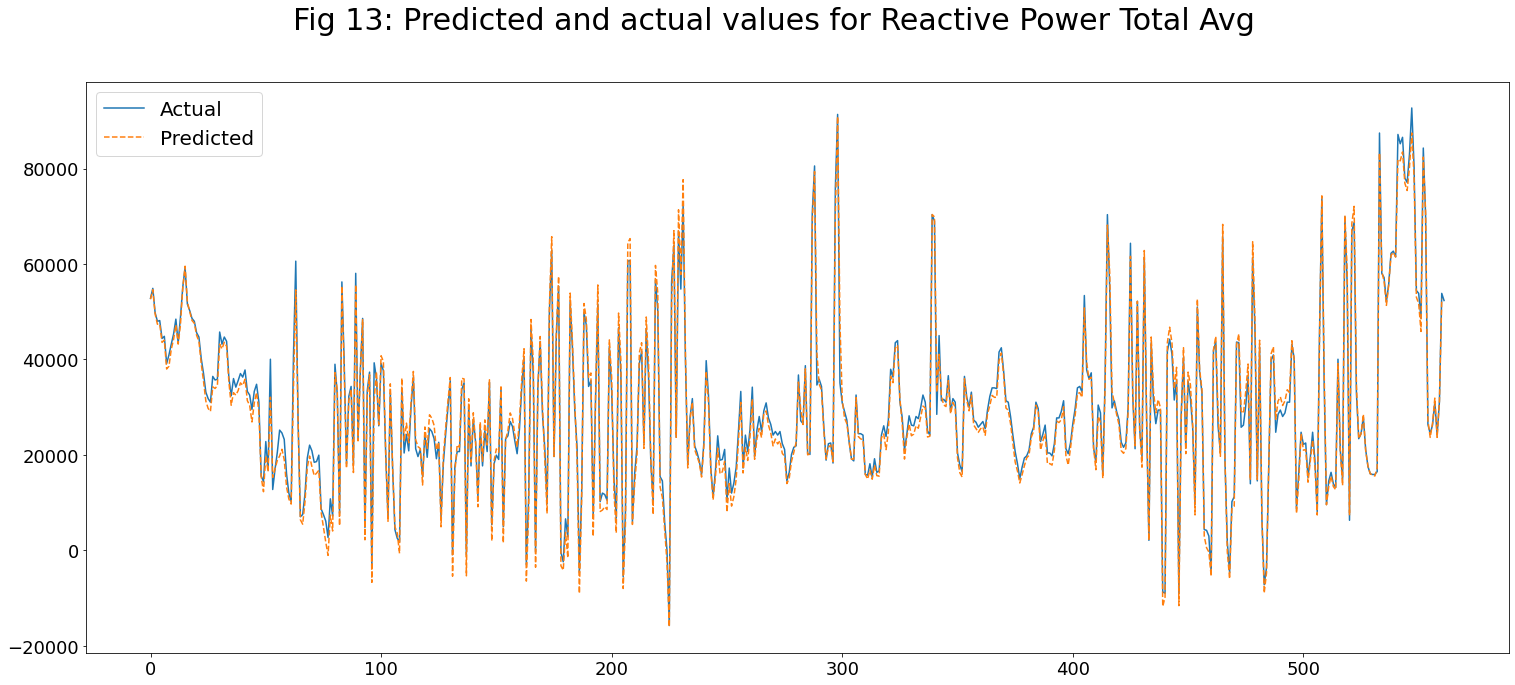

In [25]:
with open('scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
    
with open('labels.pickle', 'rb') as f:
    labels = pickle.load(f)

for i in range(validation_target.shape[1]):
    fig = plt.figure()
    fig.set_size_inches(25.5, 10.5)
    fig.suptitle("Fig "+str(i+1)+": Predicted and actual values for "+labels[i], size=30)
    plt.plot(scaler.inverse_transform(validation_target)[:, i], label='Actual')
    plt.plot(scaler.inverse_transform(np.array(validation_predictions))[:, i], '--', label='Predicted')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(prop={'size': 20})
    plt.show()